# Converting Images to Point Cloud
This notebook demonstrates how to convert images to point clouds using the [Open3D](http://www.open3d.org/) library. The images are first converted to depth maps using a pre-trained model, and then the depth maps are converted to point clouds. The point clouds are then visualized using Open3D.

In [108]:
import os
import pandas as pd
import open3d as o3d
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np 
import copy
from numpy import asarray
from PIL import Image
from transformers import pipeline

#### Import data
The data is imported from the `input` directory. These images are transformed to depth maps (saved in the `depth` directory) and then to point clouds (saved in the `point_cloud` directory).

In [109]:
data_set_name = 'bottle'
input_path = os.path.join("Data/input", data_set_name)
output_dir = os.path.join("Data/output", data_set_name)
output_dir_depth = os.path.join(output_dir,"depth")
output_dir_pcd = os.path.join(output_dir,"pcd")

os.makedirs(output_dir_depth, exist_ok=True)
os.makedirs(output_dir_pcd, exist_ok=True)

In [110]:
dir_list = os.listdir(input_path)
original_paths = []
depth_map_pahts = []
for filename in dir_list:
    if filename != None and filename.endswith(('.png')):
        image_path = os.path.join(input_path, filename)
        output_path = os.path.join(output_dir_depth, filename.split('.')[0] + '_depth.png')
        original_paths.append(image_path)
        depth_map_pahts.append(output_path)
df_paths = pd.DataFrame({'Original': original_paths, 'DepthMap': depth_map_pahts})

#### Transform images to depth maps
Function to convert images to depth maps:

In [111]:
def to_8bit(dm):
    max_pixel_value = dm.max()
    dm = dm / max_pixel_value * 255
    dm = dm.astype('uint8')
    return dm

def save_image(image, output_path):
    image_ = Image.fromarray(image)
    image_ = image_.resize((640, 480))
    image_.save(output_path)

def img_to_depth_map(depth_estimation_pipeline, image_path, output_path):
    image = Image.open(image_path)
    if image.size != (640, 480):
        image = image.resize((640, 480))

    depth_map = depth_estimation_pipeline(image)
    depth_map_tensor = depth_map['predicted_depth']
    dp = depth_map_tensor[0].numpy()

    dp = to_8bit(dp)

    # invert image
    save_image(dp, output_path)

In [112]:
# depth_estimation_pipeline = pipeline("depth-estimation", model="vinvino02/glpn-nyu")
depth_estimation_pipeline = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-small-hf")

C:\Users\yraul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [113]:
var = df_paths.apply(lambda row: img_to_depth_map(depth_estimation_pipeline, row["Original"], row['DepthMap']), axis=1)

#### Visualize Depth Map Results

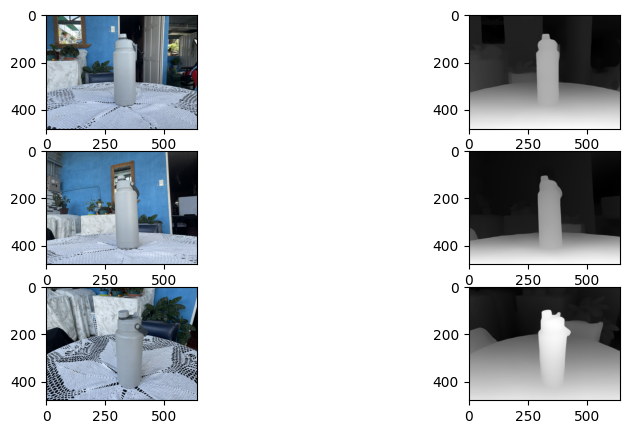

In [114]:
#display images and its maps
df_sample = df_paths.sample(3)
x, y = df_sample.shape
fig, axs = plt.subplots(x, 2, figsize=(10, 5))
for i, (index, row) in enumerate(df_sample.iterrows()):
    original_image = imread(row['Original'])
    depth_map = imread(row['DepthMap'])
    axs[i, 0].imshow(original_image)
    axs[i, 1].imshow(depth_map, cmap='gray')

#### Transform Depth Maps into Point Clouds

Build the path to the point cloud directory for every image in the `depth` directory.

In [115]:
def build_pc_output_path(image_path):
    image_name = os.path.basename(image_path)
    image_name = os.path.splitext(image_name)[0]
    return os.path.join(output_dir_pcd, image_name + '.ply')

df_paths["PointCloud"] = df_paths["Original"].apply(build_pc_output_path)

Function to convert depth maps to point clouds.
The camera parameteres doesn't correspond to the real camera parameters, but they are used to generate the point cloud.

In [116]:
def generate_pcd(image, dm):
    width, height, channels = image.shape

    depth_o3d = o3d.geometry.Image(dm)
    image_o3d = o3d.geometry.Image(image)
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        image_o3d, 
        depth_o3d, 
        convert_rgb_to_intensity=False)

    intrinsics = o3d.camera.PinholeCameraIntrinsic()
    intrinsics.set_intrinsics(width, height, 525, 525, width/2, height/2)

    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsics)

    return pcd

def depth_to_pcd(image_path, dm_path, output_path):
    image = Image.open(image_path)
    dm = Image.open(dm_path)
    dm = np.array(dm)
    image = np.array(image)

    pcd = generate_pcd(image, dm)
    o3d.io.write_point_cloud(output_path, pcd)

Transform the depth maps to point clouds and save them in the `point_cloud` directory.

In [117]:
y = df_paths.apply(lambda row: depth_to_pcd(row["Original"],row["DepthMap"], row["PointCloud"]), axis=1)

#### Visualize Sample Point Clouds

We take a random sample and visualize the point clouds.

In [127]:
pcd_path = df_paths.sample(1)["PointCloud"].values[0]    
pcd = o3d.io.read_point_cloud(pcd_path)

Text(0.5, 0.92, 'Filtered Point Cloud')

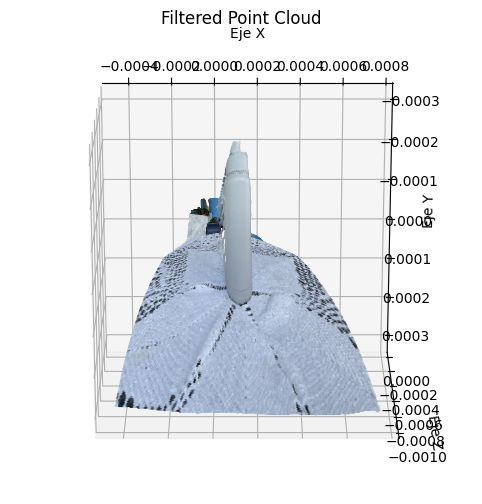

In [126]:
from mpl_toolkits.mplot3d import Axes3D


fig, (ax1) = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(12, 6))

points = np.asarray(pcd.points)
x, y , z = points[:, 0], points[:, 1], points[:, 2]
colors = np.asarray(pcd.colors)

# Graficar la nube de puntos
ax1.scatter(x, y, -z, c=colors, s=0.1)
ax1.view_init(elev=-70, azim=-90) #elevacion y rotacion
# Configurar etiquetas
ax1.set_xlabel('Eje X')
ax1.set_ylabel('Eje Y')
ax1.set_zlabel('Eje Z')
ax1.set_title('Filtered Point Cloud')

In [128]:
o3d.visualization.draw_geometries([pcd])